# ML Summer School - Assignment 4

In this assignment, we will be clustering movies on the basis of their synopsis. Unlike previous assignments, this time you will be implementing the KMeans clustering algorithm from scratch.

### Load Libraries

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
from sklearn import feature_extraction
import pickle
import scipy
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/eerie16/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/eerie16/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Load data
We will be using the synopsis of Top 100 movies ranked by IMDb. `titles`, `genres` and `synopsis` are lists stored as pickled files. We first load them into memory. 

Take a look at the lists we have just loaded.

In [2]:
titles = pickle.load(open('data/titles.pkl','rb'))
genres = pickle.load(open('data/genres.pkl','rb'))
synopsis = pickle.load(open('data/synopses.pkl','rb'))
print(len(titles), len(genres), len(synopsis))

100 100 100


### Preprocessing the Data

Let us take a look at some of the synopsis.

In [3]:
print(synopsis[0])

 Plot  [edit]  [  [  edit  edit  ]  ]  
  On the day of his only daughter's wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito's youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception. Vito's godson Johnny Fontane, a popular singer, pleads for help in securing a coveted movie role, so Vito dispatches his consigliere, Tom Hagen, to Los Angeles to influence the abrasive studio head, Jack Woltz. Woltz is unmoved until the morning he wakes up in bed with the severed head of his prized stallion.  On the day of his only daughter's wedding,   Vito Corleone  Vito Corleone   hears requests in his role as the Godfather, the   Don  Don   of a New York crime family. Vito's youngest son,   Michael  Michael  , in a   Marine Corps  Marine Corps   uniform, introduces his girlfriend,   Kay Adams  Kay Adams  , to his family at the sprawling reception. Vito's godson   Johnny

In [4]:
print(synopsis[1])

 Plot  [edit]  [  [  edit  edit  ]  ]  
  In 1947, banker Andy Dufresne is convicted of murdering his wife and her lover and sentenced to two consecutive life sentences at the fictional Shawshank State Penitentiary in the state of Maine. Andy befriends contraband smuggler Ellis "Red" Redding, an inmate serving a life sentence. Red procures a rock hammer and later a large poster of Rita Hayworth for Andy. Working in the prison laundry, Andy is regularly assaulted by the "bull queer" gang "the Sisters" and their leader, Bogs.  In 1947, banker Andy Dufresne is convicted of murdering his wife and her lover and sentenced to two consecutive life sentences at the fictional Shawshank State Penitentiary in the state of Maine. Andy befriends   contraband  contraband   smuggler Ellis "Red" Redding, an inmate serving a life sentence. Red procures a   rock hammer  rock hammer   and later a large poster of   Rita Hayworth  Rita Hayworth   for Andy. Working in the prison laundry, Andy is regularly as

We can see that the synopsis contain a lot of names (Proper Nouns) and years. They are specific to the movies and do not seem to be helpful to cluster the movies. We should remove them

We will also be lemmatizing the words. [Lemmatizing](https://www.twinword.com/blog/what-is-lemmatization/ ) refers to replacing word by its base form (lemma). For example, lemmatizing `cars` gives `car`. Lemmatizing will help in clubbing all different inflections of words, eg. `loves`, `loving`, `loved` will all be lemmatized to `love`.

### Task 1

Complete the following function `preprocess_data`. It takes in text as input, and [removes proper nouns](https://stackoverflow.com/questions/39634222/is-there-a-way-to-remove-proper-nouns-from-a-sentence-using-python), non-alphabetic words, lemmatizes the data and lower cases the entire text.

In [5]:
from nltk.stem import WordNetLemmatizer

def preprocess_data(text):
    """Removes proper noun, non-alphabetic words, lemmatizes the data and lower cases the entire text"""
    
    # YOUR CODE STARTS HERE
    lemmatizer=WordNetLemmatizer()
    words=re.compile('\w+').findall(text)
    words=[word for word in words if word.isalpha() and len(word)>2 and word not in ['the', 'his','her'] ]
    tagged=nltk.tag.pos_tag(words)
    edited_sentence = [word for word,tag in tagged if tag != 'NNP' and tag != 'NNPS']
    edited_sentence=[lemmatizer.lemmatize(word) for word in edited_sentence]
    return ' '.join(edited_sentence).lower()
    # YOUR CODE ENDS HERE
    


**Sample input**: preprocess_data(synopsis[0][:1000])


**Sample output**: 'edit edit edit day daughter wedding hears request role crime family son uniform introduces girlfriend family reception godson singer pleads help securing movie role dispatch consigliere influence studio head is unmoved morning wake bed head stallion day daughter wedding hears request role crime family son uniform introduces girlfriend family reception godson'



In [6]:
preprocess_data(synopsis[0][:1000])

'edit edit edit day only daughter wedding hears request role crime family youngest son uniform introduces girlfriend family sprawling reception godson popular singer pleads for help securing coveted movie role dispatch consigliere influence abrasive studio head unmoved until morning wake bed with severed head prized stallion day only daughter wedding hears request role crime family youngest son uniform introduces girlfriend family sprawling reception godson'

### Creating the Features

We will extract features from the synopsis using TfIdf Vectoriser, which will be used to cluster the movies. 

Read more about TfIdf Vectoriser [here](http://blog.christianperone.com/2011/09/machine-learning-text-feature-extraction-tf-idf-part-i/) and [here](http://blog.christianperone.com/2011/10/machine-learning-text-feature-extraction-tf-idf-part-ii/).

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=20000, min_df=0.2,\
                                   stop_words='english', preprocessor=preprocess_data, \
                                   use_idf=True, ngram_range=(1, 1))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopsis)

print(tfidf_matrix.shape)
terms = tfidf_vectorizer.get_feature_names()
print(len(terms))


CPU times: user 10.6 s, sys: 1.63 ms, total: 10.6 s
Wall time: 10.6 s
(100, 449)
449


In [8]:
tfidf_matrix
print(tfidf_matrix.shape[0])

100


### Task 2 - Implementing KMeans

This is the most important task of this assignment because in this, you will implement your own K-Means. Fill in the function `KMeans` which will return the labels and cluster centers in the tuple `(labels,centers)` for the given feature matrix `X` and `num_clusters`. We also pass the `max_iter` parameter to run KMeans for that many iterations as it sometimes gets stuck on a local minima. You can learn more about Kmeans clustering [here](https://en.wikipedia.org/wiki/K-means_clustering) and [here](https://www.datascience.com/blog/k-means-clustering).

**Sample Input**: `[[2,1], [2,3], [8,1], [8,3]]`, `num_clusters=2`

**Sample Output**: `([0,0,1,1], [[2,2], [8,2]])`

In [62]:
import random
def Kmeans(X, num_clusters=8, max_iter=300):
    
    # YOUR CODE STARTS HERE
    #I am setting the tolerance as 1%.Meaning iterations will stop after the change is less than 3%
    tolerance=1
    #choosing num_clusters random indices from the dataset as our cluster centres
    indices=random.sample(range(0,X.shape[0]),num_clusters)
    clust_centres=np.array([X[i] for i in indices ])
    #refining cluster centres for at most max_iter times
    for i in range(max_iter):
        clusters={}
        #all datapoints in a cluster as stored as elements of a dictionary with keys as cluster indices
        for x in range(num_clusters):
            clusters[x]=np.empty((0,X.shape[1]))
        #iterating for the min distances of each data point
        for data_point in X:
            dist_list=[np.linalg.norm(data_point - clust_centres[i]) for i in range(num_clusters)]
            #the index of the minimum distanced centre is stored in the variable data_point_cluster
            data_point_cluster=dist_list.index(min(dist_list))
            #appending the datapoint to the respective cluster
            clusters[data_point_cluster]=np.append(clusters[data_point_cluster],np.reshape(data_point,(1,X.shape[1])),axis=0)
        #creating a new empty array new_clust_centres to allow us to compare the changes after each iteration
        new_clust_centres=np.empty((0,X.shape[1]))
        for j in range(num_clusters):
            #heres the refining part. The cluster centres are shifted to the centre of their respective clusters.
            new_clust_centres=np.append(new_clust_centres,np.reshape(np.average(clusters[j],axis=0),(1,X.shape[1])),axis=0)
        more_needed=False #this variable checks if more refining is needed
        for j in range(num_clusters):
            #if the change exceeds the tolerance in any cluster, more iterations are required.
            if(np.sum(np.absolute(np.array(new_clust_centres)-np.array(clust_centres))/clust_centres *100)>tolerance):
                more_needed=True
                break
        #assign the new centres as the old centres.
        clust_centres=new_clust_centres
        #break when more refining is not required.
        if(more_needed==False):
            break
    labels=np.empty((0,))
    #finding the corresponding cluster indices for each datapoint in X
    for z in X:
        final_dist_list=[np.linalg.norm(z-clust_centres[i]) for i in range(num_clusters)]
        labels=np.append(labels,[final_dist_list.index(min(final_dist_list))])
    return (labels,np.array(clust_centres))
            # YOUR CODE ENDS HERE
    
#     return (labels, centers)

In [63]:
lab,cen=Kmeans(np.array([[2,1], [2,3], [8,1], [8,3],[8,8]]), num_clusters=2,max_iter=30)
print(lab)

[0. 0. 0. 1. 1.]


Cluster the synopsis (represented as TfIdf vectors) using Kmeans. You can play with different number of centers and maximum iterations to get different results.

In [64]:
%time (labels, centers) = Kmeans(tfidf_matrix.todense(), num_clusters=3, max_iter=1000)

CPU times: user 53.7 ms, sys: 7.94 ms, total: 61.7 ms
Wall time: 59.5 ms


/home/eerie16/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
/home/eerie16/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Now we create a dataframe `frame` that stores the the clusters labels, names and genres for all the 100 movies.

In [65]:
import pandas as pd
films = {'title': titles, 'synopsis': synopsis, 'cluster': labels, 'genre': genres}
frame = pd.DataFrame(films, index = [labels] , columns = ['title', 'cluster', 'genre'])
frame

,title,cluster,genre
2.0,The Godfather,2.0,"[u' Crime', u' Drama']"
2.0,The Shawshank Redemption,2.0,"[u' Crime', u' Drama']"
0.0,Schindler's List,0.0,"[u' Biography', u' Drama', u' History']"
1.0,Raging Bull,1.0,"[u' Biography', u' Drama', u' Sport']"
0.0,Casablanca,0.0,"[u' Drama', u' Romance', u' War']"
0.0,One Flew Over the Cuckoo's Nest,0.0,[u' Drama']
2.0,Gone with the Wind,2.0,"[u' Drama', u' Romance', u' War']"
2.0,Citizen Kane,2.0,"[u' Drama', u' Mystery']"
0.0,The Wizard of Oz,0.0,"[u' Adventure', u' Family', u' Fantasy', u' Mu..."
0.0,Titanic,0.0,"[u' Drama', u' Romance']"


Movie counts for a particular cluster.

In [66]:
frame['cluster'].value_counts()

0.0    40
2.0    36
1.0    24
Name: cluster, dtype: int64

### Interpreting Results
We sort the cluster centers to get the most important terms per cluster and store it in `cluster_names`. We print them along with the movies in that cluster and look how well has KMeans worked.

In [67]:
print("Top terms per cluster:")
order_centroids = np.asarray(centers).argsort()[:, ::-1]
order_centroids=np.reshape(order_centroids,(3,449))
cluster_names = []
print(order_centroids.shape)
for i in range(order_centroids.shape[0]):
    print("Cluster %d words:" % i, end='')
    q = ""
    for ind in order_centroids[i, :6]:
#         print(ind)
        print(' %s' % terms[ind], end=',')
#         print(terms[ind], end=" ")
        q += str(terms[ind])
        q += " "
    cluster_names.append(q)
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:
(3, 449)
Cluster 0 words: car, police, family, home, ship, away,
Cluster 0 titles: Schindler's List, Casablanca, One Flew Over the Cuckoo's Nest, The Wizard of Oz, Titanic, Psycho, Vertigo, Star Wars, E.T. the Extra-Terrestrial, 2001: A Space Odyssey, The Silence of the Lambs, Chinatown, It's a Wonderful Life, 12 Angry Men, Unforgiven, Rocky, A Streetcar Named Desire, Butch Cassidy and the Sundance Kid, The Treasure of the Sierra Madre, The Exorcist, The French Connection, Mr. Smith Goes to Washington, Fargo, The Grapes of Wrath, The Green Mile, Close Encounters of the Third Kind, Network, Nashville, American Graffiti, Pulp Fiction, Stagecoach, Mutiny on the Bounty, The Maltese Falcon, A Clockwork Orange, Taxi Driver, Double Indemnity, Rebel Without a Cause, Rear Window, The Third Man, North by Northwest,

Cluster 1 words: soldier, fight, men, war, order, water,
Cluster 1 titles: Raging Bull, Lawrence of Arabia, On the Waterfront, West Side Story, The Bridge on t

### Plotting the Data
Now we plot the various movie clusters.
Basically we scale the multi-dimentional feature vector by applying 2 dimensional PCA. It is a technique used to visualize multi-dimensional plots in 2 dimensions. More about it [here](http://www.apnorton.com/blog/2016/12/19/Visualizing-Multidimensional-Data-in-Python/).

In [68]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA

In [69]:
pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(tfidf_matrix.todense()))

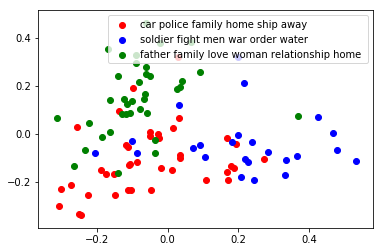

In [70]:
colors = ['red', 'blue', 'green', 'yellow', 'black', 'gray', 'orange', 'brown']
for i in range(len(cluster_names)):
    plt.scatter(transformed[labels == i][0], transformed[labels == i][1], label=cluster_names[i], c=colors[i])
plt.legend()
plt.show()

# And you're done!